In [10]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import json
import ast
import os

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans



In [48]:
songs_all = pd.read_csv('unique_songs_features_complete.csv')
songs_all.info()

df = pd.read_csv('lastfm_user_clean.csv')
print(df.info())
print(df.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129890 entries, 0 to 129889
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   track_name_original   129889 non-null  object 
 1   artist_name_original  129889 non-null  object 
 2   lyrics                129890 non-null  object 
 3   duration_ms           129890 non-null  float64
 4   listeners             129890 non-null  float64
 5   total_playcount       129890 non-null  float64
 6   toptags               129890 non-null  object 
 7   profanity_density     129890 non-null  float64
 8   polarity              129890 non-null  float64
 9   subjectivity          129890 non-null  float64
 10  emotion1              129890 non-null  object 
 11  emotion1_score        129890 non-null  float64
 12  emotion2              129890 non-null  object 
 13  emotion2_score        129890 non-null  float64
 14  mfcc                  129890 non-null  object 
 15  

In [49]:
user_top = df[['Username', 'Top_50']]
# user_top.head()

def safe_eval(x):
    try:
        return ast.literal_eval(x)
    except:
        return x
user_top['Top_50'] = user_top['Top_50'].apply(safe_eval)
user_top = user_top.explode('Top_50')
user_top[['track_name', 'artist_name', 'rank', 'playcount']] = pd.DataFrame(user_top['Top_50'].tolist(), index=user_top.index)
user_top = user_top.drop(['Top_50'], axis=1).reset_index(drop=True)
user_top.info()

C:\Users\e0559632\AppData\Local\Temp\ipykernel_12968\891505245.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_top['Top_50'] = user_top['Top_50'].apply(safe_eval)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498255 entries, 0 to 498254
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Username     498255 non-null  object
 1   track_name   498255 non-null  object
 2   artist_name  498255 non-null  object
 3   rank         498255 non-null  object
 4   playcount    498255 non-null  object
dtypes: object(5)
memory usage: 19.0+ MB


In [55]:
user_songs = pd.merge(user_top, songs_all, how='inner', left_on=['track_name', 'artist_name'], right_on=['track_name_original', 'artist_name_original']).drop(['track_name_original', 'artist_name_original'], axis=1).reset_index(drop=True)
pd.set_option('display.max_columns', None)
user_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250053 entries, 0 to 250052
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Username           250053 non-null  object 
 1   track_name         250053 non-null  object 
 2   artist_name        250053 non-null  object 
 3   rank               250053 non-null  object 
 4   playcount          250053 non-null  object 
 5   lyrics             250053 non-null  object 
 6   duration_ms        250053 non-null  float64
 7   listeners          250053 non-null  float64
 8   total_playcount    250053 non-null  float64
 9   toptags            250053 non-null  object 
 10  profanity_density  250053 non-null  float64
 11  polarity           250053 non-null  float64
 12  subjectivity       250053 non-null  float64
 13  emotion1           250053 non-null  object 
 14  emotion1_score     250053 non-null  float64
 15  emotion2           250053 non-null  object 
 16  em

In [66]:
counts = user_songs['Username'].value_counts().to_dict()
threshold = 25
user_songs_filtered = user_songs[user_songs.groupby('Username')['Username'].transform('size') >= threshold]
user_songs_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 173599 entries, 0 to 250052
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Username           173599 non-null  object 
 1   track_name         173599 non-null  object 
 2   artist_name        173599 non-null  object 
 3   rank               173599 non-null  object 
 4   playcount          173599 non-null  object 
 5   lyrics             173599 non-null  object 
 6   duration_ms        173599 non-null  float64
 7   listeners          173599 non-null  float64
 8   total_playcount    173599 non-null  float64
 9   toptags            173599 non-null  object 
 10  profanity_density  173599 non-null  float64
 11  polarity           173599 non-null  float64
 12  subjectivity       173599 non-null  float64
 13  emotion1           173599 non-null  object 
 14  emotion1_score     173599 non-null  float64
 15  emotion2           173599 non-null  object 
 16  emotion

In [67]:
user_songs_filtered.to_csv('user_songs_filtered.csv', index=False)

In [68]:
user_songs_filtered = pd.read_csv('user_songs_filtered.csv')
user_songs_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173599 entries, 0 to 173598
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Username           173599 non-null  object 
 1   track_name         173599 non-null  object 
 2   artist_name        173599 non-null  object 
 3   rank               173599 non-null  int64  
 4   playcount          173599 non-null  int64  
 5   lyrics             173599 non-null  object 
 6   duration_ms        173599 non-null  float64
 7   listeners          173599 non-null  float64
 8   total_playcount    173599 non-null  float64
 9   toptags            173599 non-null  object 
 10  profanity_density  173599 non-null  float64
 11  polarity           173599 non-null  float64
 12  subjectivity       173599 non-null  float64
 13  emotion1           173599 non-null  object 
 14  emotion1_score     173599 non-null  float64
 15  emotion2           173599 non-null  object 
 16  em

## EDA

In [5]:
# Descriptive Statistics
numerical_cols = ['playcount',
                  'artist_count',
                  'track_count',
                  'album_count',
                  'registered_year',
                  ]

descriptive_stats = df[numerical_cols].describe().loc[['min', 'max', 'mean', 'std', '50%']].transpose()
descriptive_stats.columns = ['min', 'max', 'mean', 'std', 'median']
descriptive_stats['mode'] = df[numerical_cols].mode().transpose()[0]
descriptive_stats['mad'] = [stats.median_abs_deviation(df[x]) for x in numerical_cols]
descriptive_stats['kurtosis'] = [stats.kurtosis(df[x], fisher=False) for x in numerical_cols]
descriptive_stats['skewness'] = [stats.skew(df[x]) for x in numerical_cols]
descriptive_stats

,min,max,mean,std,median,mode,mad,kurtosis,skewness
playcount,0.0,8463249.0,113356.554123,166606.613800,74776.0,0,48280.0,673.882259,16.504432
artist_count,0.0,139439.0,3619.024188,5592.206766,2197.0,1,1342.0,138.921502,8.751268
track_count,0.0,427379.0,20748.606297,27427.188396,12703.0,1,8163.0,41.127629,4.764983
album_count,0.0,192746.0,6913.037581,9591.512136,4244.0,0,2654.0,71.076527,6.086159
registered_year,2002.0,2024.0,2015.903448,5.485402,2018.0,2021,4.0,1.891182,-0.456785


As we can observe from discriptive statistics, the various music playing counts of users are quite postively skewed. The positive skewness of music playing counts suggests that most users have relatively low playcounts, but there are a few users with extremely high playcounts, resulting in the right-skewed distribution.

Out of these, `playcount` and `album_count` have mode value of 0. This could mean that a significant number of users have not played any songs or albums, respectively. For example, it could be due to inactive accounts, new users who have not started using the platform yet. However, it could also be due to users who listen to music but do not scrobble their plays to Last.fm, since the users have non-empty `Top_50` songs lists. 

The users have a wide range of registration year from 2002 to 2024. Moving on, we plot histograms to visualize the distribution of these numerical columns. 

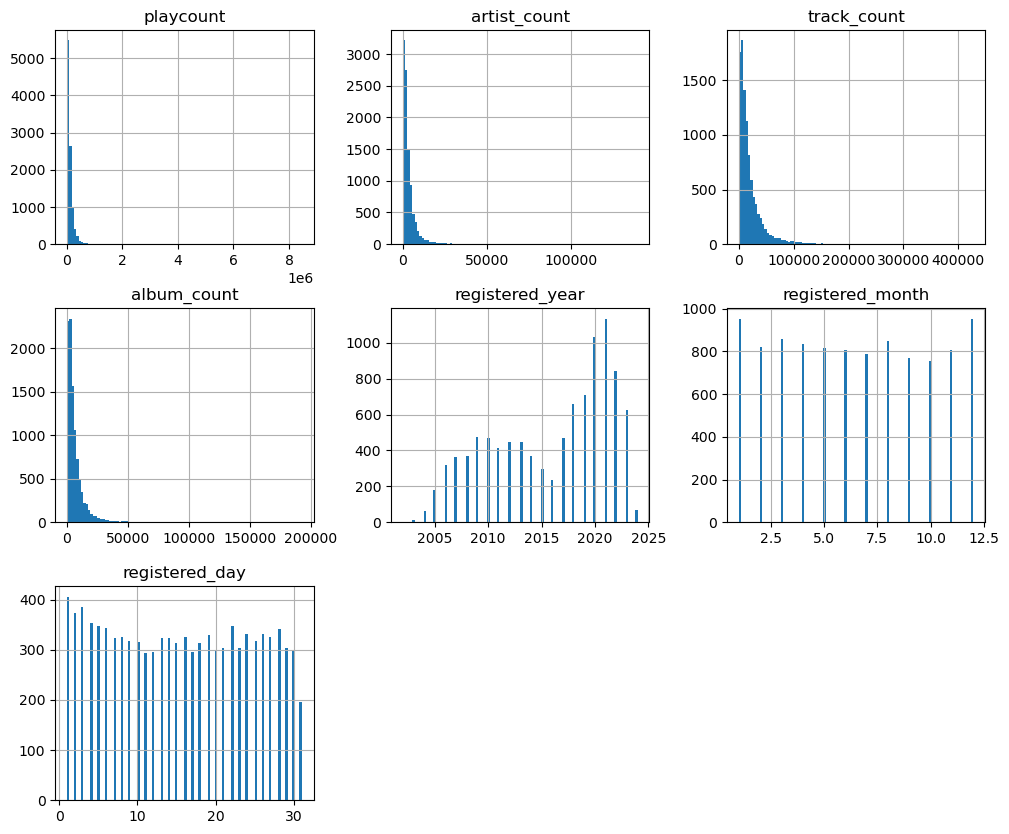

In [6]:
# histogram of features to observe the distribution of values
ax = df.hist(figsize = (12, 10), bins = 100)

From the above analysis and visualization, we find `track_count` to be the most representative music playing counts among the four for users' activeness on the platform. There are extreme outliers in this value, therefore, we have decided to transform it into categorical variable, though risking losing some information. 

In [7]:
# transform track_count to categorical
categories = pd.cut(df.track_count, bins = [0, 4600, 9500, 16000, 30000, 450000],
                    labels = ["most inactive", "inactive", "medium", "active", "most active"])
categories.value_counts(normalize = True)

track_count
active           0.211142
inactive         0.203441
most active      0.199640
medium           0.194539
most inactive    0.191238
Name: proportion, dtype: float64

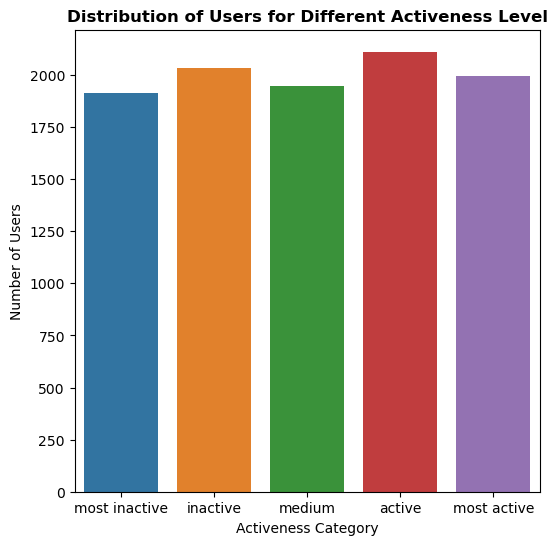

In [10]:
# try the above category, plot the percentage of frauds in each category
df['active_category'] = categories

plt.figure(figsize=(6, 6))
sns.countplot(x = 'active_category', data = df)
plt.xlabel('Activeness Category')
plt.ylabel('Number of Users')
plt.title('Distribution of Users for Different Activeness Level', fontsize = 12, fontweight = 'bold')
plt.show()

In [11]:
df['type'].value_counts()

type
user          8527
subscriber    1473
staff            4
mod              1
Name: count, dtype: int64

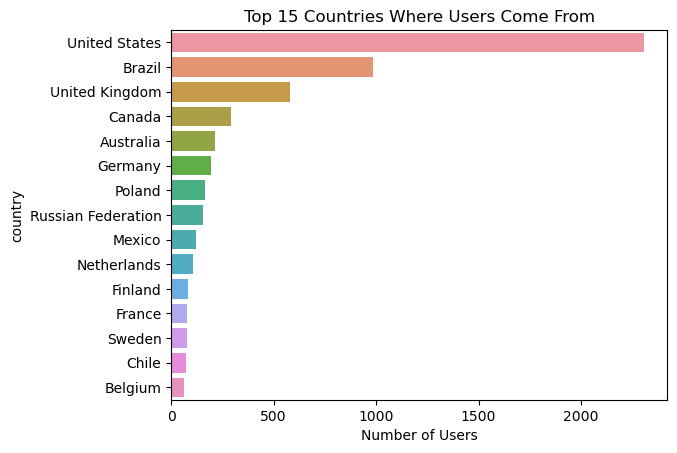

In [12]:
# Observe where users come from
nocountry = df['country'] == 'None'
df.loc[nocountry, 'country'] = 'Not Indicated'
countries = df.groupby(['country']).agg({"Username":'count'}).reset_index()
countries = countries.sort_values(by = 'Username', ascending = False).head(15)
sns.barplot(y = countries.country, x = countries.Username).set(title = 'Top 15 Countries Where Users Come From')
plt.xlabel('Number of Users')
plt.show()


We can see that except for users who did not indicate their countries, most users come from the US, Brazil, UK, Canada and Australia.

<Axes: xlabel='track_count', ylabel='registered_year'>

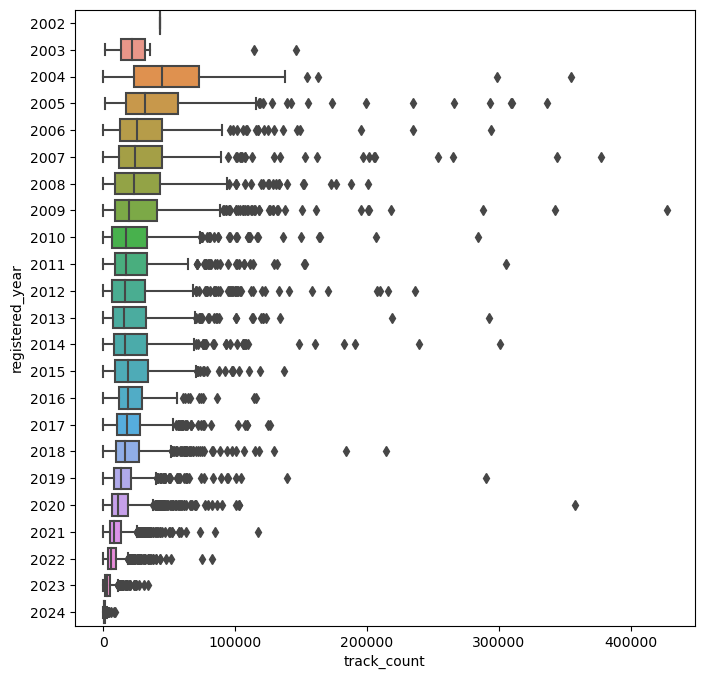

In [13]:
plt.figure(figsize=(8, 8))

df['registered_year'] = df['registered_year'].astype('category')
type(df['registered_year'][0])
sns.boxplot(y = 'registered_year', x = 'track_count', data = df)


## EDA-Songs

feature description:
- Zero Crossing Rate: the rate at which the sound signal changes from positive to negative and vice versa. This feature is usually used for speech recognition and music information retrieval. Music genre with high percussive sound like rock or metal usually have high Zero Crossing Rate than other genres.
- Tempo BMP (beats per minute): Tempo is the number of beat per one minute.
- Spectral Centroid: This variable represents brightness of a sound by calculating the center of sound spectrum (where the sound signal is at its peak). We can also plot it into a wave form.
- Mel-Frequency Cepstral Coefficients: The Mel frequency Cepstral coefficients (MFCCs) of a signal are a small set of features that describes the overall shape of a spectral envelope. It imitates characteristics of human voice.
- Chroma Frequencies: Chroma feature represents the tone of music or sound by projecting its sound spectrum into a space that represents musical octave. This feature is usually used in chord recognition task.

In [43]:
songs_all = pd.read_csv('unique_songs_features_complete.csv')
songs_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129890 entries, 0 to 129889
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   track_name_original   129889 non-null  object 
 1   artist_name_original  129889 non-null  object 
 2   lyrics                129890 non-null  object 
 3   duration_ms           129890 non-null  float64
 4   listeners             129890 non-null  float64
 5   playcount             129890 non-null  float64
 6   toptags               129890 non-null  object 
 7   profanity_density     129890 non-null  float64
 8   polarity              129890 non-null  float64
 9   subjectivity          129890 non-null  float64
 10  emotion1              129890 non-null  object 
 11  emotion1_score        129890 non-null  float64
 12  emotion2              129890 non-null  object 
 13  emotion2_score        129890 non-null  float64
 14  has_lyrics            129890 non-null  int64  
 15  

In [ ]:

def parse_array(s):
    if pd.isna(s):
        return np.array([])  
    numbers = s.strip("[]").split()  
    return np.array([float(num) for num in numbers])


df = pd.read_excel("../../Downloads/ReRun7.xlsx")
df = df[["mfcc", "chroma", "rms", "spectral_centroid", "zcr", "tempo"]]
pca = PCA()
df = df.dropna(subset=['mfcc', 'chroma', 'rms', 'spectral_centroid', 'zcr', 'tempo'])
df['mfcc'] = df['mfcc'].apply(parse_array)

df['mfcc'] = df['mfcc'].apply(lambda x: np.array(x))

df['mfcc'] = df['mfcc'].apply(lambda x: x.flatten())

X = np.stack(df['mfcc'].values, axis=0)

pca = PCA()
X_pca = pca.fit_transform(X)

print("Explained variance ratio of each component:", pca.explained_variance_ratio_)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
def parse_array(s):
    if pd.isna(s):
        return np.array([])  
    numbers = s.strip("[]").split()  
    return np.array([float(num) for num in numbers])


df = pd.read_excel("../../Downloads/ReRun7.xlsx")
df = df[["mfcc", "chroma", "rms", "spectral_centroid", "zcr", "tempo"]]
df = df.dropna(subset=['mfcc', 'chroma', 'rms', 'spectral_centroid', 'zcr', 'tempo'])
df['mfcc'] = df['mfcc'].apply(parse_array)

df['mfcc'] = df['mfcc'].apply(lambda x: np.array(x))

df['mfcc'] = df['mfcc'].apply(lambda x: x.flatten())

X = np.stack(df['mfcc'].values, axis=0)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5)
plt.title('t-SNE visualization of the dataset')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

In [ ]:
# convert high dimensional numerical data to low dimensions
numerical_cols = [  'duration',
                    'listeners',
                    'playcount',
                    'profanity_density',
                    'polarity',
                    'subjectivity',
                    'emotion1_score',
                    'emotion2_score',
                    'has_lyrics']
tsne_model = TSNE(n_components = 2, random_state = 0)
tsne_data = tsne_model.fit_transform(songs[numerical_cols])
plt.figure(figsize = (7, 7))
plt.scatter(tsne_data[:,0], tsne_data[:,1])
plt.show()

In [ ]:
def ohe_prep(df, column, new_name):     
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df


In [ ]:

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X)

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, alpha=0.5, cmap='viridis')
plt.title('t-SNE visualization with K-Means clusters')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

## audio features EDA & PCA
https://taridwong.github.io/posts/2021-12-11-applying-machine-learning-to-audio-data/